In [1]:
# PyTorch: This is the base library on which Hugging Face transformers, which include SBERT, is built.
# Transformers: This library from Hugging Face includes the pretrained SBERT model.
# Datasets: Another library from Hugging Face, which will allow us to easily load and preprocess datasets.
# Matplotlib: This library is used for generating plots to help us visualize our results.
# Scikit-learn: This library has many useful tools for machine learning, including a function to calculate cosine similarity.
# Pandas: This library is a powerful tool for data manipulation and analysis. We'll use it for examining our dataset.
# Seaborn: A statistical data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

!pip install torch
!pip install transformers
!pip install datasets
!pip install matplotlib
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install plotly
!pip install ipykernel
!pip install nbformat




/Users/mdj/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                       sentence1  \
0                         A plane is taking off.   
1                A man is playing a large flute.   
2  A man is spreading shreded cheese on a pizza.   
3                   Three men are playing chess.   
4                    A man is playing the cello.   

                                           sentence2  label  idx  
0                        An air plane is taking off.   5.00    0  
1                          A man is playing a flute.   3.80    1  
2  A man is spreading shredded cheese on an uncoo...   3.80    2  
3                         Two men are playing chess.   2.60    3  
4                 A man seated is playing the cello.   4.25    4  
             label         idx
count  5749.000000  5749.00000
mean      2.700999  2874.00000
std       1.464398  1659.73768
min       0.000000     0.00000
25%       1.500000  1437.00000
50%       3.000000  2874.00000
75%       3.800000  4311.00000
max       5.000000  5748.00000


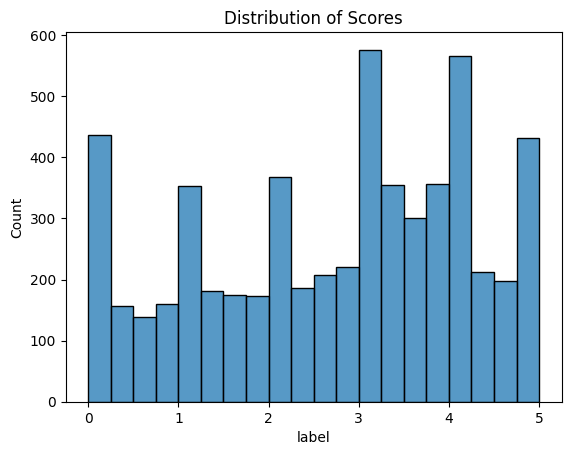

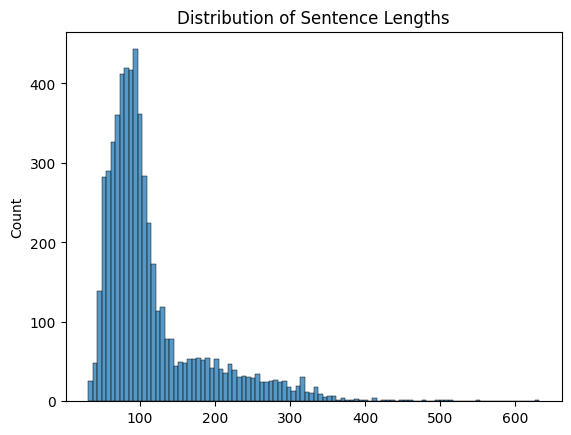

In [2]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
dataset = load_dataset('glue', 'stsb')

# Convert the dataset to a pandas DataFrame for easy analysis
df = pd.DataFrame(dataset['train'])

# Display the first few rows of the DataFrame
print(df.head())

# Get some basic statistics about the dataset
print(df.describe())

# Visualize the distribution of scores
sns.histplot(df['label'])
plt.title('Distribution of Scores')
plt.show()

# Visualize the distribution of sentence lengths
sentence_lengths = df['sentence1'].apply(len) + df['sentence2'].apply(len)
sns.histplot(sentence_lengths)
plt.title('Distribution of Sentence Lengths')
plt.show()


# Fine-tuning a model involves several steps:

- Preprocessing the data: The data needs to be converted into a format that the model can understand. In the case of SBERT, this involves tokenizing the sentences.
- Creating a dataloader: The dataloader is a PyTorch object that efficiently loads the data in batches.
- Defining the model and optimizer: We need to create instances of the SBERT model and the optimizer that we will use to train it.
- Training loop: The training loop is where the actual learning happens. It involves running the model on the training data, calculating the loss, and updating the model's parameters.
- Evaluation loop: After each epoch of training, it's common to run the model on a validation set to see how well it's performing.

In [3]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

# Preprocessing the data
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
train_encodings = tokenizer(df['sentence1'].tolist(), df['sentence2'].tolist(), truncation=True, padding=True)

# Creating a PyTorch dataset
class STSBDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = STSBDataset(train_encodings, df['label'].tolist())

# Creating a dataloader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [4]:
# Defining the model and optimizer
model = AutoModelForSequenceClassification.from_pretrained('sentence-transformers/all-MiniLM-L6-v2', num_labels=1)
optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/mdj/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


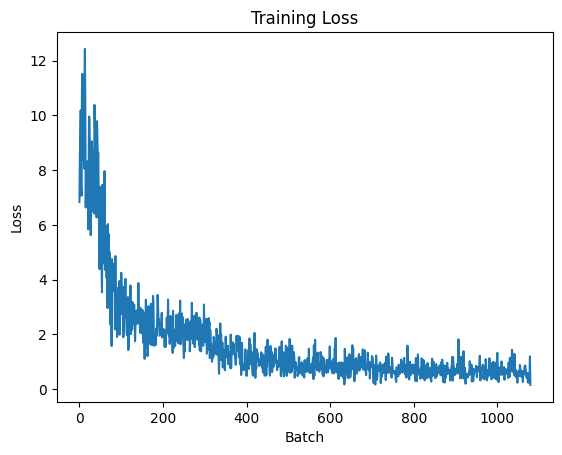

100%|██████████| 360/360 [00:45<00:00,  7.91it/s]


In [5]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Prepare a list to save loss values
loss_values = []

# Training loop
for epoch in range(3):  # we'll train for 3 epochs
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Save the loss value for this batch
        loss_values.append(loss.item())
        # Clear the previous plot
        clear_output(wait=True)
        # Plot the loss values
        plt.plot(loss_values)
        plt.title('Training Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.show()


# Evaluation loop
model.eval()
with torch.no_grad():
    for batch in tqdm(train_loader):
        outputs = model(**batch)
        logits = outputs.logits
        # Here you could calculate some metric based on the logits and the labels


In [6]:
# Validation Set
from sklearn.metrics import mean_squared_error


# Convert the validation dataset to a pandas DataFrame
val_df = pd.DataFrame(dataset['validation'])

# Preprocess the validation data
val_encodings = tokenizer(val_df['sentence1'].tolist(), val_df['sentence2'].tolist(), truncation=True, padding=True)

# Create a PyTorch dataset for the validation data
val_dataset = STSBDataset(val_encodings, val_df['label'].tolist())

# Create a dataloader for the validation data
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Evaluation loop
model.eval()
all_logits = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(val_loader):
        outputs = model(**batch)
        logits = outputs.logits
        all_logits.append(logits)
        all_labels.append(batch['labels'])

mse = mean_squared_error(torch.cat(all_labels).numpy(), torch.cat(all_logits).numpy())
print(f'Validation Mean Squared Error: {mse}')


100%|██████████| 94/94 [00:08<00:00, 10.48it/s]

Validation Mean Squared Error: 0.7757673859596252


In [8]:
# Test the model by getting embeddings

from transformers import AutoModel
import numpy as np
from scipy.spatial.distance import cosine


# Define an instance of AutoModel
embedding_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Define three sample sentences
sentence1 = "A dog is running in the park."
sentence2 = "A canine is jogging in the park."
sentence3 = "An apple is a type of fruit."

# Tokenize the sentences
inputs1 = tokenizer(sentence1, return_tensors='pt', truncation=True, padding=True)
inputs2 = tokenizer(sentence2, return_tensors='pt', truncation=True, padding=True)
inputs3 = tokenizer(sentence3, return_tensors='pt', truncation=True, padding=True)

# Compute the embeddings
with torch.no_grad():
    embedding_model.eval()
    outputs1 = embedding_model(**inputs1)
    outputs2 = embedding_model(**inputs2)
    outputs3 = embedding_model(**inputs3)

# Perform mean pooling to get sentence embeddings
embeddings1 = outputs1.last_hidden_state.mean(dim=1).numpy()[0]
embeddings2 = outputs2.last_hidden_state.mean(dim=1).numpy()[0]
embeddings3 = outputs3.last_hidden_state.mean(dim=1).numpy()[0]

# Compute the cosine similarity between the embeddings
similarity1_2 = 1 - cosine(embeddings1, embeddings2)
similarity1_3 = 1 - cosine(embeddings1, embeddings3)

print(f'Similarity between sentence 1 and 2: {similarity1_2}')
print(f'Similarity between sentence 1 and 3: {similarity1_3}')


Similarity between sentence 1 and 2: 0.9087390303611755
Similarity between sentence 1 and 3: 0.058103274554014206


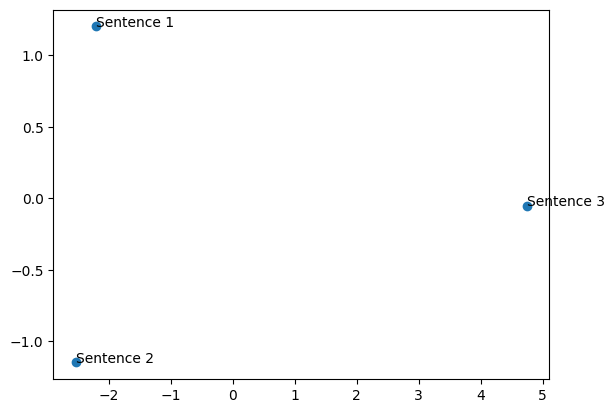

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Put the embeddings in a list
embeddings = [embeddings1, embeddings2, embeddings3]

# Create a PCA object
pca = PCA(n_components=2)

# Fit the PCA object to the embeddings and transform the embeddings
embeddings_pca = pca.fit_transform(embeddings)

# Create a plot
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1])

# Add labels to the points
for i, txt in enumerate(["Sentence 1", "Sentence 2", "Sentence 3"]):
    plt.annotate(txt, (embeddings_pca[i,0], embeddings_pca[i,1]))

plt.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


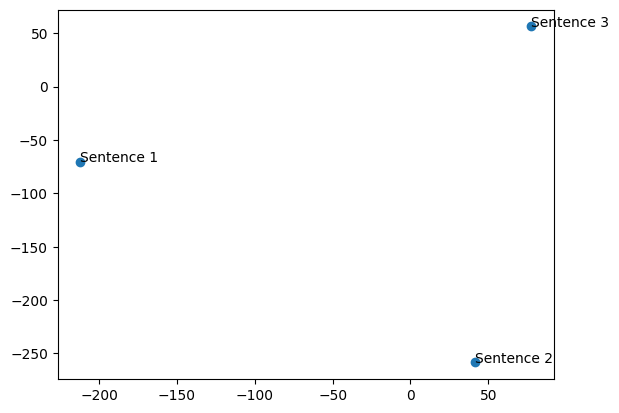

In [10]:
from sklearn.manifold import TSNE
import numpy as np

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings)

# Create a t-SNE object with perplexity less than the number of samples
tsne = TSNE(n_components=2, perplexity=2)

# Fit the t-SNE object to the embeddings and transform the embeddings
embeddings_tsne = tsne.fit_transform(embeddings_array)

# Create a plot
plt.scatter(embeddings_tsne[:,0], embeddings_tsne[:,1])

# Add labels to the points
for i, txt in enumerate(["Sentence 1", "Sentence 2", "Sentence 3"]):
    plt.annotate(txt, (embeddings_tsne[i,0], embeddings_tsne[i,1]))

plt.show()


In [11]:
import plotly.express as px
from sklearn.manifold import TSNE
import numpy as np

# Define a larger set of sentences
sentences = ["A dog is running in the park.",
             "A canine is jogging in the park.",
             "An apple is a type of fruit.",
             "The cat sat on the mat.",
             "A man is playing a guitar.",
             "The sun is shining brightly today.",
             "It's raining cats and dogs."]

# Compute the embeddings for all sentences
embeddings = []
with torch.no_grad():
    embedding_model.eval()
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
        outputs = embedding_model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).numpy()[0])

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce the dimensionality of the embeddings to 3 dimensions
tsne = TSNE(n_components=3, perplexity=2)
embeddings_tsne = tsne.fit_transform(embeddings_array)

# Create a DataFrame with the reduced embeddings and the sentences
df = pd.DataFrame(embeddings_tsne, columns=['x', 'y', 'z'])
df['sentence'] = sentences

# Create an interactive 3D scatter plot of the reduced embeddings
fig = px.scatter_3d(df, x='x', y='y', z='z', text='sentence')
fig.show()
